*Josh Albano, Sharon Jan, and Luke Sherman*

*2020.5.10*

In [122]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import datetime
from pandas.plotting import register_matplotlib_converters
import geopandas as gp

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import re

from IPython.display import display, Latex, Markdown

### Research Question: Can counties' responses to COVID-19 accurately predict various political features?

# Load Datasets

### Datasets
- states_df = State features dataframe
- counties_df = County features dataframe (missing some counties, Alaska, and Hawaii)
- time_cases_df = Timeline of cases by county
- county_pres_df = Presidential election results by county


### Cleaning steps
- Get rid of all non-US states (including territories & cruise ships).
- Get rid of Alaska & Hawaii in states, time_cases, and time_deaths because it is not in counties_df
- In time_cases & time_deaths, there are 'Out of State' & 'Unassigned' observations that seem like they're state-level. We split those off from the county-specific information for now.
- Convert FIPS columns to strings so they can be used as a merge key later. 
- Rename state FIPS "STATEFP" and county FIPS remains "FIPS"
- Get rid of most demographic features in counties_df; we only want to keep response features

In [2]:
#States DF
states_df = pd.read_csv("4.18states.csv")
states_df = states_df[states_df['FIPS'].notna()] #Get rid of non-US "states"
states_df = states_df[states_df['FIPS']<60] #Get rid of US territories
states_df = states_df[states_df['FIPS'] != 2] #Get rid of Alaska
states_df = states_df[states_df['FIPS'] != 15] #Get rid of Hawaii
states_df['FIPS'] = states_df['FIPS'].apply(lambda x: '0'+str(int(x)) if len(str(int(x)))==1 \
                                            else str(int(x))) #Convert FIPS to String
states_df = states_df.rename(columns={'FIPS': 'STATEFP'})
STATEFP = states_df.pop('STATEFP')
states_df.insert(0, 'STATEFP', STATEFP)
states_df = states_df.drop(columns=['UID', 'ISO3','Country_Region'])

#Counties DF
counties_df = pd.read_csv("abridged_couties.csv")
counties_df.loc[counties_df.StateName == 'VA', 'State'] = 'Virginia'
counties_df.loc[counties_df.StateName == 'VA', 'STATEFP'] = 51.0
counties_df = counties_df[counties_df['State'].notna()] #Get rid of US Territories
counties_df['STATEFP'] = counties_df['STATEFP'].apply(lambda x: '0'+str(int(x)) if len(str(int(x)))==1 else str(int(x)))
#counties_df = counties_df.rename(columns={'countyFIPS': 'FIPS'}) 
counties_df = counties_df.rename(columns={'countyFIPS': 'FIPS'}).drop(columns=['COUNTYFP'])
counties_keep_features = ['FIPS', 'STATEFP', 'CountyName', 'StateName', 'State','stay at home',
 '>50 gatherings',
 '>500 gatherings',
 'public schools',
 'restaurant dine-in',
 'entertainment/gym']
counties_old_df = counties_df.copy()
counties_df = counties_df[counties_keep_features] #Create new, abridged counties

#Time Cases & Time Deaths DFs
time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv")

def fips_to_string(df, fips_name, length=5):
    """
    Returns series of FIPS code in string form. Length tells you what length the string should be
    """
    return df[fips_name].apply(lambda x: '0' + str(int(x)) if len(str(int(x)))==length-1 \
                              else str(int(x)))

def clean_time_dfs(df):
    """
    This cleans time_cases & time_deaths and returns a county-level df and state-level df
    """
time_cases_df = time_cases_df[time_cases_df['FIPS'] >100] # Get rid of US Territories & Cruise Ships
time_cases_df = time_cases_df[time_cases_df['Province_State'].isin(['Diamond Princess','Grand Princess'])==False]
time_cases_df['FIPS'] = fips_to_string(time_cases_df, 'FIPS', 5)
time_cases_df['STATEFP'] = time_cases_df['FIPS'].str[0:2]
FIPS = time_cases_df.pop('FIPS')
time_cases_df.insert(0, 'FIPS', FIPS)
STATEFP = time_cases_df.pop('STATEFP')
time_cases_df.insert(0, 'STATEFP', STATEFP)
time_cases_df = time_cases_df[time_cases_df['STATEFP'].isin(['02','15'])==False] #Get rid of Alaska & Hawaii
state_time_cases = time_cases_df.groupby(['STATEFP','Province_State']).sum()
#Split off "Out of [State]" & "Unassigned" Data. Remove from df
time_cases_df = time_cases_df[time_cases_df['STATEFP'].isin(['80','90'])==False]
time_cases_df = time_cases_df.drop(columns = ['UID', 'iso2', 'iso3', 'code3','Country_Region', 'Lat', 'Long_', 'Combined_Key'])

#County presidential election data
county_pres_df = pd.read_csv('countypres_2000-2016.csv')
county_pres_df = county_pres_df[(county_pres_df['party'] == 'democrat') | (county_pres_df['party'] == 'republican')]
county_pres_df['candidatevotes'].fillna(0, inplace=True)
county_pres_df.dropna(inplace=True)

county_pres_df = county_pres_df[(county_pres_df['county'] != 'Broomfield')]
#                                (county_pres_df['county'] != 'Kansas City') &
#                                (county_pres_df['county'] != 'Bedford')]

county_pres_df.loc[:, 'proportion'] = county_pres_df['candidatevotes'] / county_pres_df.loc[:, 'totalvotes']
county_pres_df.loc[::2, 'proportion'] = -county_pres_df.loc[::2, 'proportion']
county_pres_df['proportion'].fillna(0, inplace=True)
county_pres_df['FIPS'] = fips_to_string(county_pres_df, 'FIPS', 5)
county_pres_df['STATEFP'] = county_pres_df['FIPS'][0:2]
FIPS = county_pres_df.pop('FIPS')
county_pres_df.insert(0, 'FIPS', FIPS)
STATEFP = county_pres_df.pop('STATEFP')
county_pres_df.insert(0,'STATEFP',STATEFP)

# County shapefile
county_shp = gp.read_file('cb_2018_us_county_5m.shp')
county_shp = county_shp.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')]
county_shp['FIPS'] = county_shp['STATEFP'] + county_shp['COUNTYFP']
county_shp = county_shp.drop(columns=['COUNTYFP'])
STATEFP = county_shp.pop('STATEFP')

# Dependent  Variables - Election Results

We have created some categorical and continuous political variables that we hope to explain using only states'/counties' COVID-19 responses. Essentially, using only information about COVID-19, can we predict a county/state's political leanings? In this section, we are merging these features into our counties and states datasets.

#### Functions for County-Level Election Data

In [3]:
def County_Winners(df, state, method='categorical'):
    """
    df: DataFrame
    state: U.S. State Name (e.g. California, Idaho, etc.)
    method: 
    
    Returns
    """
    assert method is 'categorical' or 'continuous', "Please choose either 'categorical' or 'continuous'"
    if method is 'categorical':
        max_col = 'party'
    elif method is 'continuous':
        max_col = 'proportion'
    
    state_df = df[df['state'] == state]

    election_years = state_df['year'].unique()
    winners_container = [[] for _ in range(len(election_years))]
    
    for idx, year in enumerate(election_years):
        winners = state_df[state_df['year'] == year].groupby('FIPS').apply(
            lambda county: county[max_col][county['candidatevotes'].idxmax()]).values
        winners_container[idx] = winners
            
    return winners_container

def County_Winners_DF(df, method='categorical'):
    """
    df: 
    
    Returns 
    """
    states = df['state'].unique()
    list_counties, list_fips = [], []
    list_2000, list_2004 = [], []
    list_2008, list_2012 = [], []
    list_2016 = []
    
    for state in states:
        state_df = df[df['state'] == state]
        fips = state_df['FIPS'].unique()
        county_winners = County_Winners(df=df, state=state, method=method)
        list_fips.extend(fips)
        list_2000.extend(county_winners[0])
        list_2004.extend(county_winners[1])
        list_2008.extend(county_winners[2])
        list_2012.extend(county_winners[3])
        list_2016.extend(county_winners[4])
    
    final_dataframe = pd.DataFrame({
    'FIPS': list_fips,
    '2000': list_2000, '2004': list_2004, 
    '2008': list_2008, '2012': list_2012,
    '2016': list_2016})
    
    if method is 'categorical':
        final_dataframe.replace({'republican': 1, 'democrat': 0}, inplace=True)
    else:
        pass
        
    final_dataframe['Total'] = final_dataframe.loc[:, ('2000', '2004', '2008', '2012', '2016')].mean(axis=1)
    
    return final_dataframe

In [4]:
county_winners_cat_df = County_Winners_DF(county_pres_df)
county_winners_cont_df = County_Winners_DF(county_pres_df, method='continuous')

### Google Mobility Data

Here, we load in an additional dataset, Google's Mobility Report. This gives a measure of mobility before and during the COVID-19 crisis.

In [5]:
# Clean mobility data
mob = pd.read_csv('Global_Mobility_Report.csv')
mob = mob[mob['country_region'] == 'United States'].iloc[:, 2:]
mob.reset_index(inplace=True)
mob.drop(columns='index', inplace=True)
new_cols = ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']
mob.columns = ['State', 'CountyName', 'date'] + new_cols
mob.loc[:, 'CountyName'] = mob.loc[:, 'CountyName'].str.replace(' County', '')
mob.loc[:, 'date_ord'] = pd.to_datetime(mob['date']).map(pd.Timestamp.toordinal)
mob = mob[(mob['State'] != 'Alaska') & (mob['State'] != 'Hawaii')]
mob.loc[(mob['State'] == 'Virginia'), 'CountyName'] = mob.loc[(mob['State'] == 'Virginia'), 'CountyName'].str.replace(' City', '')

for partitive in ['De', 'La', 'Du']:
    mob.loc[:, 'CountyName'] = mob.loc[:, 'CountyName'].str.replace(partitive+'[A-Z]', 
                               lambda m: m.group()[:2]+ ' ' +m.group()[2:], regex=True)

mob = mob[mob['date_ord'] > 737490]

# Create state level and county level mobility data
state_mob = mob[mob['CountyName'].isna()== True]
state_mob = state_mob[state_mob['State'].isna()== False]
state_mob_pivoted = pd.pivot_table(state_mob, index=['State'])
county_mob = mob[mob['CountyName'].isna() == False]
county_mob_pivoted = pd.pivot_table(county_mob, index=['State','CountyName'])
county_mob_pivoted.interpolate(inplace=True)

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Merge all datasets on county level and state level

Our final datasets, to be test-train-split, are county_merged_df (for county level data), and state_merged_df (for state level data)

In [6]:
county_merged_df = counties_df.merge(county_winners_cat_df.loc[:, ('FIPS', '2016')], on='FIPS')
county_merged_df.rename(columns={'2016': 'VotedTrump2016'}, inplace=True)
county_merged_df = county_merged_df.merge(county_winners_cont_df.loc[:, ('FIPS', '2016', 'Total')], on='FIPS')
county_merged_df.rename(columns={'2016': 'VotedTrump2016Cont', 'Total':'PresElectCont'}, inplace=True)

county_merged_df.loc[:, 'CountyName'] = county_merged_df.loc[:, 'CountyName'].str.replace('St ', 'St. ')
county_merged_df.loc[(county_merged_df.StateName == 'VA'), 'CountyName'] = county_merged_df.loc[(county_merged_df.StateName == 'VA'), 'CountyName'].str.replace(' City', '')

#Merged time deaths - SJ ; again we dont use this anywhere. I suggest we delete it..

#county_merged_df = county_merged_df.merge(time_deaths_df, on=('FIPS','STATEFP')) 

county_merged_df = county_merged_df.merge(county_mob_pivoted, on=['State', 'CountyName'])
    
county_merged_df

FIPS STATEFP   CountyName StateName      State  stay at home  \
0     01001      01      Autauga        AL    Alabama      737519.0   
1     01003      01      Baldwin        AL    Alabama      737519.0   
2     01005      01      Barbour        AL    Alabama      737519.0   
3     01007      01         Bibb        AL    Alabama      737519.0   
4     01009      01       Blount        AL    Alabama      737519.0   
5     01011      01      Bullock        AL    Alabama      737519.0   
6     01013      01       Butler        AL    Alabama      737519.0   
7     01015      01      Calhoun        AL    Alabama      737519.0   
8     01017      01     Chambers        AL    Alabama      737519.0   
9     01019      01     Cherokee        AL    Alabama      737519.0   
10    01021      01      Chilton        AL    Alabama      737519.0   
11    01023      01      Choctaw        AL    Alabama      737519.0   
12    01025      01       Clarke        AL    Alabama      737519.0   
13    01027      01         Clay        AL    Alabama      737519.0   
14    01029      01     Cleburne        AL    Alabama      737519.0   
15    01031      01       Coffee        AL    Alabama      737519.0   
16    01033      01      Colbert        AL    Alabama      737519.0   
17    01035      01      Conecuh        AL    Alabama      737519.0   
18    01037      01        Coosa        AL    Alabama      737519.0   
19    01039      01    Covington        AL    Alabama      737519.0   
20    01041      01     Crenshaw        AL    Alabama      737519.0   
21    01043      01      Cullman        AL    Alabama      737519.0   
22    01045      01         Dale        AL    Alabama      737519.0   
23    01047      01       Dallas        AL    Alabama      737519.0   
24    01049      01      De Kalb        AL    Alabama      737519.0   
25    01051      01       Elmore        AL    Alabama      737519.0   
26    01053      01     Escambia        AL    Alabama      737519.0   
27    01055      01       Etowah        AL    Alabama      737519.0   
28    01057      01      Fayette        AL    Alabama      737519.0   
29    01059      01     Franklin        AL    Alabama      737519.0   
...     ...     ...          ...       ...        ...           ...   
2709  55129      55     Washburn        WI  Wisconsin      737509.0   
2710  55131      55   Washington        WI  Wisconsin      737509.0   
2711  55133      55     Waukesha        WI  Wisconsin      737509.0   
2712  55135      55      Waupaca        WI  Wisconsin      737509.0   
2713  55137      55     Waushara        WI  Wisconsin      737509.0   
2714  55139      55    Winnebago        WI  Wisconsin      737509.0   
2715  55141      55         Wood        WI  Wisconsin      737509.0   
2716  56001      56       Albany        WY    Wyoming      737512.0   
2717  56003      56     Big Horn        WY    Wyoming      737512.0   
2718  56005      56     Campbell        WY    Wyoming      737512.0   
2719  56007      56       Carbon        WY    Wyoming      737512.0   
2720  56009      56     Converse        WY    Wyoming      737512.0   
2721  56011      56        Crook        WY    Wyoming      737512.0   
2722  56013      56      Fremont        WY    Wyoming      737512.0   
2723  56015      56       Goshen        WY    Wyoming      737512.0   
2724  56017      56  Hot Springs        WY    Wyoming      737512.0   
2725  56019      56      Johnson        WY    Wyoming      737512.0   
2726  56021      56      Laramie        WY    Wyoming      737512.0   
2727  56023      56      Lincoln        WY    Wyoming      737512.0   
2728  56025      56      Natrona        WY    Wyoming      737512.0   
2729  56029      56         Park        WY    Wyoming      737512.0   
2730  56031      56       Platte        WY    Wyoming      737512.0   
2731  56033      56     Sheridan        WY    Wyoming      737512.0   
2732  56035      56     Sublette        WY    Wyoming      737512.0   
2733  56037      56   Sweetwate

We also load in a binary feature, 'State Voted Trump,' as another political categorical variable for the state-level data.

In [7]:
def temp(i):
    if len(i) < 2:
        i = '0' + i
    else:
        pass
    return i

presidential_df = pd.read_csv('1976-2016-president.csv')
presidential_df = presidential_df[presidential_df['year'] == 2016]
presidential_df = presidential_df[(presidential_df['party'] == 'republican') | 
                                  (presidential_df['party'] == 'democrat')]

winners = presidential_df.groupby('state').apply(lambda state: state['candidate'][state['candidatevotes'].idxmax()]).values
state_winners_df = pd.DataFrame({'STATEFP' : [temp(i) for i in presidential_df['state_fips'].unique().astype(str)],
                                 'StateVotedTrump' : winners})
state_winners_df.loc[:, 'StateVotedTrump'] = (state_winners_df['StateVotedTrump'] ==  'Trump, Donald J.').astype(int)

#state_merged_df = state_time_deaths.merge(state_winners_df, on=('STATEFP')) # again, we dont use this data can we get rid of it - LS
#state_merged_df = state_merged_df.merge(states_df[['STATEFP','Province_State']], on='STATEFP')

state_merged_df = state_winners_df.merge(states_df[['STATEFP','Province_State']], on='STATEFP') # LS rewrote these lines to exclude death data

statename = state_merged_df.pop('Province_State')
state_merged_df.insert(0, 'State', statename)
state_merged_df = state_merged_df.merge(state_mob_pivoted, on=['State'], how='inner')
state_merged_df.head()

State STATEFP  StateVotedTrump  date_ord    grocery      parks  \
0     Alabama      01                1    737516  -0.274510  13.352941   
1     Arizona      04                1    737516  -7.274510 -12.725490   
2    Arkansas      05                1    737516   0.862745  34.725490   
3  California      06                0    737516 -10.941176 -29.235294   
4    Colorado      08                0    737516 -10.490196   1.509804   

   residential     retail    transit  workplaces  
0    10.882353 -24.470588 -18.666667  -27.941176  
1    12.117647 -28.019608 -29.647059  -33.705882  
2     9.235294 -19.588235 -16.862745  -25.392157  
3    17.019608 -38.509804 -45.019608  -38.411765  
4    15.313725 -34.686275 -44.647059  -38.470588

#  Train Test Split

This will be done on the state-level (i.e. 80/20 split of the states) and county-level (80/20 split on all counties)

In [8]:
import sklearn.model_selection

def train_test_split_fips(unique_fips, fips_level, df):
    """
    Inputs:
    unique_fips = list of unique FIPS
    fips_level: either 'STATEFP' or 'FIPS'
    df_list: list of dataframes to train/test
    Returns:
    list of train/test splits of each dataframe: eg: [df1_train, df1_test, df2_train, df_test]
    """
    assert (fips_level == 'FIPS' or fips_level == 'STATEFP'), "Please enter 'STATEFP' or 'FIPS' for fips_level"

    #Train/Test Split FIPS IDs
    tr, te = sklearn.model_selection.train_test_split(
    unique_fips, train_size=0.8, test_size=0.2, random_state=47, shuffle=True)
    
    return df[df[fips_level].isin(tr)], df[df[fips_level].isin(te)]

In [9]:
#Unique Fips Codes
statefp = state_merged_df['STATEFP'].unique()
countyfp = county_merged_df['FIPS'].unique()

#State Level DFs
state_train, state_test = train_test_split_fips(statefp, 'STATEFP', state_merged_df)

#County Level DFs (doesn't include states_df)
county_train, county_test = train_test_split_fips(countyfp, 'FIPS', county_merged_df)

print("State train size: ", state_train.shape[0], ", state test size: ", state_test.shape[0])
print("County train size: ", county_train.shape[0], ", county test size: ", county_test.shape[0])

State train size:  39 , state test size:  10
County train size:  2191 , county test size:  548


In [10]:
#Shape file merge? Haven't touched yet
#final_cat_merged = shape.merge(county_merged_df, on=['STATEFP', 'COUNTYFP'])
#final_cat_merged = final_cat_merged.loc[:, ('FIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'State', 'stay at home', 
#                    '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym',
#                    'date_ord', 'grocery', 'parks', 'residential', 'retail', 'transit', 'workplaces', '2000', '2004', '2008', '2012', 
#                    '2016', 'Total','geometry')]
#final_cat_merged.to_csv('final_cat_merged.csv', index=False)

#mob_merged = cont_merged.merge(pd.pivot_table(mob, index=['State', 'CountyName']), 
 #                              on=['State', 'CountyName'], how='inner')

#final_cont_merged = shape.merge(mob_merged, on=['STATEFP', 'COUNTYFP'])
#final_cont_merged = final_cont_merged.loc[:, ('FIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'State', 'stay at home', 
#                    '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym',
##                    '2016', 'Total','geometry')]
#final_cont_merged.to_csv('final_cont_merged.csv', index=False)

In [11]:
# could we instead change this visualization so it's not random? It's hard to know what this means. Also, what is the X axis? - LS


## County order features EDA

Below is a graph of three random counties' workplace mobility data.

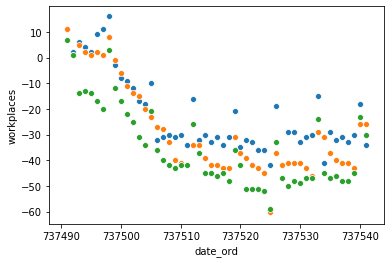

In [12]:
county1, state1 = county_train.iloc[1]['CountyName'], county_train.iloc[1]['State']
county2, state2 = county_train.iloc[500]['CountyName'], county_train.iloc[500]['State']
county3, state3 = county_train.iloc[1000]['CountyName'], county_train.iloc[1000]['State']

sns.scatterplot('date_ord', 'workplaces', data=mob[(mob['CountyName'] == county1) \
                                                            & (mob['State'] == state1)])
sns.scatterplot('date_ord', 'workplaces', data=mob[(mob['CountyName'] == county2) \
                                                            & (mob['State'] == state2)])
sns.scatterplot('date_ord', 'workplaces', data=mob[(mob['CountyName'] == county3) \
                                                            & (mob['State'] == state3)])

Let's look at the distribution of stay at home orders by county:

Text(0.5, 1.0, 'Distribution of stay at home orders by US county')

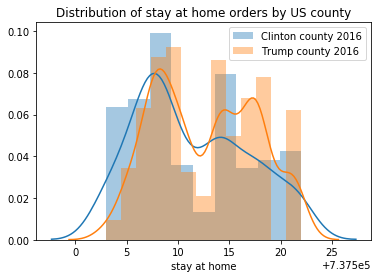

In [13]:
for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub["stay at home"].dropna())
plt.legend(["Clinton county 2016", "Trump county 2016"])

plt.title("Distribution of stay at home orders by US county")

# State Order Features
Okay, now what I really want to do is understand how policies, like "stay at home orders" impact the new daily cases by county.

Creates some new features to describe: 
- Earliest order in state (for all orders)
- Latest order in state (for all orders)
- Whether state had same order across the state (for all orders)
- County's order date relative to state

In [14]:
# This function converts ordinal date to pandas date

def convert_ordinal_date_series_to_pd_date(series_object):
    """
    This function takes a series object of ordinal dates (days from the beginning of the 
    Gregorian calendar) and returns a pandas date time object series
    """
    #series_object = series_object.astype(int)
    k = []
    y = 0
    
    for ordinal_date in series_object:
        if np.isnan(ordinal_date) == True:
            y += 1
            k.append(np.nan)
            
        else:
            ordinal_date = int(ordinal_date)
            k.append(pd.to_datetime(datetime.datetime.fromordinal(ordinal_date)))
    print("Your series has", y, "NaNs. This function converts them to NaTs.")
    return pd.Series(k, index = series_object.index)

In [15]:
def state_orders_features(df, col, statefp= 'STATEFP'):
    """
    Inputs: df (dataframe), column (string of column name), statefp = STATEFP column
    Outputs a list of series: 
    1) The earliest date for the order, 
    2) The latest date for the order,
    3) Whether every county in the state has the same date of order (most likely a state order)
    4) Whether a county's order was before the median of the state (assuming the median will be the state order)
    """
    return [df[col].groupby(df[statefp]).transform(min),
            df[col].groupby(df[statefp]).transform(max),
            df[col].groupby(df[statefp]).transform(min) == df[col].groupby(df[statefp]).transform(max),
            df[col] - df[col].groupby(df[statefp]).transform('median')]

def add_state_orders_features_to_df(df, orders_columns, statefp = 'STATEFP'):
    """
    Adds state_orders_features to dataframe
    """
    for col in orders_columns:
        df['Earliest '+ col] = state_orders_features(df, col, statefp)[0]
        df['Latest '+ col] = state_orders_features(df, col, statefp)[1]
        df[col + ' same for whole state'] = state_orders_features(df, col, statefp)[2]
        df[col + ' relative to state'] = state_orders_features(df, col, statefp)[3]
    return df

In [16]:
# Apply state_orders_features and add_state_orders_features_to_df 

pd.set_option('mode.chained_assignment', None) #this is to make that slice error go away
orders_columns = ['stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym']

county_train = add_state_orders_features_to_df(county_train, orders_columns)

# Characterizing time series data (disease growth)

### Simple time series model

A simple way to think about the time series data would be to fit it with a simple quadratic equation of the form:

$new.cases = \beta_1~time + \beta_2~time^2$

The advantage of this model, is that it characterizes the curve with just two parameters. Because the growth should begin at (0,0) there is no need for an intercep parameter. Functionally, this forces the quadratic to go through the origin.

The function to calculate this model for states is below. It includes a plotting option.

In [17]:
#This function re-reads the dataset. We're probably not keeping the quadratic function features so I think its fine

def quadratic_time_series_model_daily_cases_state(state, threshold=300, min_observation_days=15, plot=False,intercept=False):
    """
    Function to get beta values for a quadratic time series model.
    Use state name variable to specify the relevant state region. 
    Threshold is a scalar for the total number of cases in a region before beginning to fit the model.
    Has an option to generate a basic plot when plot = True.
    Minimum observation days sets a minimum number of days since the threshold case value was reached to calculate the model.
    If the minimum observation days are not met, the function returns a list of nans.
    
    Returns a list of intercept, beta_1, and beta_2 in the model below
    
    ***
    FORMULA
    daily_new_cases = beta_0 + beta_1*days_since_threshold_cases + beta_2*days_since_threshold_cases^2
   """
    time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv") # I'm reloading this dataset here because the function below doesn't work with the way other teammates cleaned the data
    pd.set_option('mode.chained_assignment', None)
    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]
    date_column_begin = 11
    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]
    df = df.melt(ids).rename(columns = {"value" : "cases"})
    date = pd.to_datetime(df["variable"], format="%m/%d/%y")
    df["date"] = date
    county_df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()
    county_df = county_df[county_df["Province_State"] == state]
    zero = np.array([0])
    new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
    county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame
    county_df = county_df[county_df["cases"] >= threshold]
        
    if len(county_df) < min_observation_days:
        return [np.nan, np.nan, np.nan]
    else:
        county_df["days_since_threshold"] = np.arange(0,len(county_df))
        county_df["days_since_threshold^2"] = county_df["days_since_threshold"]**2

        lm = LinearRegression(fit_intercept = intercept)
        x = county_df[["days_since_threshold","days_since_threshold^2"]]
        y = np.array(county_df["daily_new_cases"]).reshape(-1,1)
        lm.fit(x,y)

        if plot == True:
            y_hat = lm.predict(x)
            plt.plot(county_df["days_since_threshold"], (county_df["daily_new_cases"]))
            plt.plot(county_df["days_since_threshold"], y_hat)

            plot_title_string = county_df["Province_State"].iloc[0]
            plt.title("Quadratic modeling of daily cases for {}".format(plot_title_string))
            plt.ylabel("Daily new cases")
            plt.xlabel("days since {} cases".format(threshold))

        if intercept == True:
            return [lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1]]
        else:
            return [0, lm.coef_[0][0], lm.coef_[0][1]]
        
def create_state_beta_table(threshold=300, min_observation_days=15, intercept=False):
    
    time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv") # I'm reloading this dataset here because the function below doesn't work with the way other teammates cleaned the data
    pd.set_option('mode.chained_assignment', None)
    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]
    date_column_begin = 11
    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])] 
    df = df[-df["FIPS"].isna()] #drop cases with no FIPS ID
    df = df.melt(ids).rename(columns = {"value" : "cases"})
    date = pd.to_datetime(df["variable"], format="%m/%d/%y")
    df["date"] = date   
    df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()    
    zero = np.array([0])
    
    k = []    
    for state in np.unique(time_cases_df["Province_State"]):     
        county_df = df[df["Province_State"] == state]
        zero = np.array([0])
        new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
        county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame
        county_df = county_df[county_df["cases"] >= threshold]

        if len(county_df) < min_observation_days:
            k.append([np.nan, np.nan, np.nan])            
        else:
            county_df["days_since_threshold"] = np.arange(0,len(county_df))
            county_df["days_since_threshold^2"] = county_df["days_since_threshold"]**2

            lm = LinearRegression()
            x = county_df[["days_since_threshold","days_since_threshold^2"]]
            y = np.array(county_df["daily_new_cases"]).reshape(-1,1)
            lm.fit(x,y)
            
            if intercept == True:
                k.append([lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1] ])
            else:
                k.append([0, lm.coef_[0][0], lm.coef_[0][1] ])
        
    state_betas = pd.DataFrame(k).rename(columns = {0:"beta0",1:"beta1",2:"beta2"})
    state_betas.index = np.unique(time_cases_df["Province_State"])

    return(state_betas)


[0, 74.15744786287604, -1.0570409363453805]

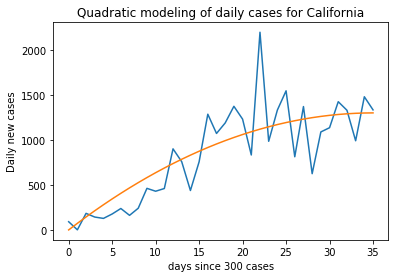

In [18]:
quadratic_time_series_model_daily_cases_state("California", plot=True, intercept=False)

[0, 18.106329459277866, -0.6196223816717951]

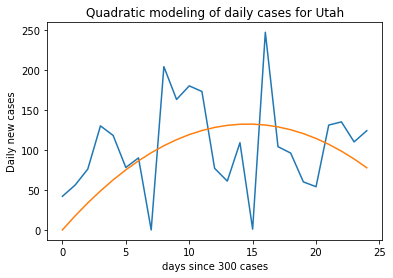

In [19]:
quadratic_time_series_model_daily_cases_state("Utah", plot=True, intercept=False)

Now let's look at the distribution of these beta values with respect to our political features.

In [20]:
state_train = pd.merge(state_train, create_state_beta_table(), left_on="State", right_index=True)

Text(0.5, 1.0, 'Distribution of state beta 2 values')

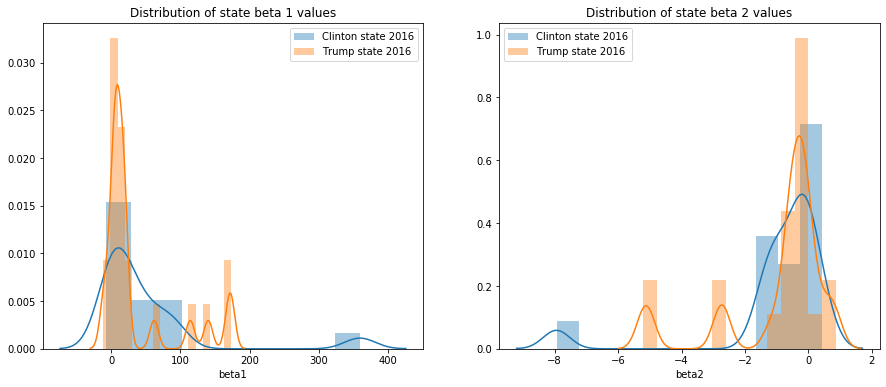

In [21]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

for trump in range(0,2):
    state_sub = state_train[state_train["StateVotedTrump"]== trump]
    sns.distplot(state_sub["beta1"].dropna(), ax=ax[0])
    
ax[0].legend(["Clinton state 2016", "Trump state 2016"])
ax[0].set_title("Distribution of state beta 1 values")

for trump in range(0,2):
    state_sub = state_train[state_train["StateVotedTrump"]== trump]
    sns.distplot(state_sub["beta2"].dropna(), ax=ax[1])
    
ax[1].legend(["Clinton state 2016", "Trump state 2016"])
ax[1].set_title("Distribution of state beta 2 values")

Unfortunately, it looks like the quadratic model doesn't really show much variance. States with large outbreaks have higher much higher $\beta_1$ and $\beta_2$ values in absolute terms, but there is not an even distribution.

## Estimating the Effective Reproductive Number (R)

The issue with the quadratic model is that it really just shows the intensity of the outbreaks, not the true rate of transmission. This is because it has the incorrect functional form. Disease outbreaks should be modeled as exponentials. Epidimiologists use the Reproductive Number $R$ to describe disease outbreaks.

I'm going to now build a function to estimate the Effective Reproductive Number $R$ so that we can use it as a parameter in our models. This should better characterize the multipication of the disease irrespective of how large the outbreak is any given region.

More information here:

https://en.wikipedia.org/wiki/Basic_reproduction_number

***

**Equations from wikipedia:**

$R=e^{K\tau}$

$K = \cfrac{d}{dt} ln(N(t))$

$\tau = \text{the serial interval}$

$N(t) = \text{an exponential time series for the number of cases over time (t}$


***

**My own math for these calculations:**

$N(t) = e^{kt}$

$ln(N(t)) = ln(e^{kt})$


$ln(N(t)) = kt*ln(e)$

$ln(N(t)) = kt$

$\frac{d}{dt}ln(N(t)) = k$

***
Let's start by estimating  $R$ based off only the last 3 weeks (21 days). The reasoning for this is that a variety of factors related to behavioral and political intervention should have a differential effect on $R$. In the early stages of this outbreak, we might expect less consistent efforts.

Note that $R$ estimations also requre a serial interval $\tau$ that indicates how many days it take for each person to spread the disease. I'm estimating that it takes 7 days in the function below, based on media reports.

In [22]:
def calculate_R(state_or_FIPS, start_date=67, end_date=88, serial_interval = 7, min_obs=15):
    """
    calculates R value using either State names (must be strings) or FIPS codes (must be numeric). 
    Altetantively, input a Pandas Series object of state strings or FIPS codes.
    
    Specify time series start date and end date over the period day 0 to day 88
    
    Serial interval is the time lag (in days) for the spread of the disease
    
    min obs is a minimum number of observed case reporting days for each instance
    
    Returns the basic reproductive number R, and the associated K
    
    LaTeX FORMULAS
    
    $R_0=e^{K~\tau}$

    $K = \cfrac{d~ ln(N(t))}{dt}$

    $\tau = \text{the serial interval}$

    $N(t) = \text{an exponential time series for the number of cases over time (t}$

    """

    pd.set_option('mode.chained_assignment', None) 
    ids = ["FIPS","Admin2", "Province_State"]
    date_column_begin = 4
    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]  
    df["FIPS"] = pd.to_numeric(df["FIPS"])   
    df = df.melt(ids).rename(columns = {"value" : "cases"})
    date = pd.to_datetime(df["variable"], format="%m/%d/%y")
    df["date"] = date


    if isinstance(state_or_FIPS, pd.Series):
        j = []   
        fips_table = df.pivot_table(values = "cases", index = ["FIPS", "date", "Province_State"],  aggfunc=sum).reset_index()
                
        for code in state_or_FIPS:
            #print(code)
            if isinstance(code, str):
                county_df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()
                county_df = county_df[county_df["Province_State"] == code]
            else:
                county_df = fips_table[fips_table["FIPS"] == code]
                
            zero = np.array([0])
            new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
            county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFram
            county_df = county_df.iloc[start_date:end_date+1]
            county_df["days"] = np.arange(0,len(county_df))
            county_df = county_df[county_df["daily_new_cases"] > 0]

            if len(county_df) < min_obs: #an in if statement here in case there are no cases
                j.append([np.nan,np.nan])
            else:
                lm = LinearRegression()
                x = np.array(county_df["days"]).reshape(-1,1)
                y = np.log(np.array(county_df["daily_new_cases"]).reshape(-1,1))
                lm.fit(x,y)

                K = lm.coef_[0]
                R = np.exp(lm.coef_[0] * serial_interval)
                j.append([R[0], K[0]])

        values = pd.DataFrame(j).rename(columns = {0:"R",1:"K"})
        values.index = state_or_FIPS
        return values

    elif isinstance(state_or_FIPS, str):
        county_df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()
        county_df = county_df[county_df["Province_State"] == state_or_FIPS]
    else:
        county_df = df.pivot_table(values = "cases", index = ["FIPS", "date", "Admin2", "Province_State"],  aggfunc=sum).reset_index()
        county_df = county_df[county_df["FIPS"] == state_or_FIPS]

    zero = np.array([0])
    new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
    county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame

    county_df = county_df.iloc[start_date:end_date+1]
    county_df["days"] = np.arange(0,len(county_df))
    county_df = county_df[county_df["daily_new_cases"] > 0]
    
    if len(county_df) < min_obs:
        return [np.nan, np.nan]
    else:
        lm = LinearRegression()
        x = np.array(county_df["days"]).reshape(-1,1)
        y = np.log(np.array(county_df["daily_new_cases"]).reshape(-1,1))
        lm.fit(x,y)

        K = lm.coef_[0]
        R = np.exp(lm.coef_[0] * serial_interval)  
        print("R,K for" ,state_or_FIPS)
        return R[0], K[0]

Below, are some examples of how to use this function:

In [23]:
calculate_R("California")

R,K for California


(1.043303999061838, 0.006056085653360178)

In [24]:
calculate_R(6001) # This looks at R for a numeric FIPS code!

R,K for 6001


(1.1727195571576703, 0.022760779911390708)

In [25]:
states = pd.Series(np.unique(time_cases_df["Province_State"]))
Rs = calculate_R(states)
Rs.head(10)

R         K
Alabama               1.310210  0.038598
Arizona               0.990022 -0.001433
Arkansas              1.270427  0.034193
California            1.043304  0.006056
Colorado              1.283584  0.035665
Connecticut           1.333251  0.041089
Delaware              1.785005  0.082774
District of Columbia  1.317815  0.039425
Florida               1.047769  0.006666
Georgia               1.268211  0.033944

In [26]:
calculate_R("Georgia")

R,K for Georgia


(1.2682106346994593, 0.03394385113041857)

In [27]:
calculate_R(6001) # This looks at R for a numeric FIPS code!

R,K for 6001


(1.1727195571576703, 0.022760779911390708)

These Rs (and Ks) are for the last three weeks of the outbreak per the default parameters of the function. We could similarly estimate $R$ over a different time period using optional parameters of the same functions. 

### Merging R estimations

In [28]:
##County Train Merge
county_train["numeric_FIPS"] = pd.to_numeric(county_train["FIPS"])

R_df = calculate_R(county_train["numeric_FIPS"])["R"].rename("R_last_3_weeks")
R_df = pd.DataFrame(R_df)
R_df["R_last_6_weeks"] = calculate_R(county_train["numeric_FIPS"], start_date = 46 )["R"]

county_train = pd.merge(county_train, R_df, left_on = "numeric_FIPS", right_index=True)

In [29]:
##State Train Merge

R_df = calculate_R(state_train["State"])["R"].rename("R_last_3_weeks")
R_df = pd.DataFrame(R_df)
R_df["R_last_6_weeks"] = calculate_R(state_train["State"], start_date = 46 )["R"]

state_train = pd.merge(state_train, R_df, left_on = "State", right_index=True)


Now, let's examine if these R values can tell us anything about a simple political binary variable

In [30]:
state_train.head()

State STATEFP  StateVotedTrump  date_ord    grocery      parks  \
0     Alabama      01                1    737516  -0.274510  13.352941   
1     Arizona      04                1    737516  -7.274510 -12.725490   
2    Arkansas      05                1    737516   0.862745  34.725490   
3  California      06                0    737516 -10.941176 -29.235294   
4    Colorado      08                0    737516 -10.490196   1.509804   

   residential     retail    transit  workplaces  beta0      beta1     beta2  \
0    10.882353 -24.470588 -18.666667  -27.941176    0.0  16.407425 -0.432553   
1    12.117647 -28.019608 -29.647059  -33.705882    0.0   8.568596 -0.228816   
2     9.235294 -19.588235 -16.862745  -25.392157    0.0   4.649976 -0.133855   
3    17.019608 -38.509804 -45.019608  -38.411765    0.0  93.061622 -1.500801   
4    15.313725 -34.686275 -44.647059  -38.470588    0.0  32.468041 -0.852440   

   R_last_3_weeks  R_last_6_weeks  
0        1.310210        2.101688  
1        0.990022        2.192635  
2        1.270427        1.574975  
3        1.043304        2.178941  
4        1.283584        1.794353

Text(0.5, 1.0, 'Distribution of county R values past 6 weeks')

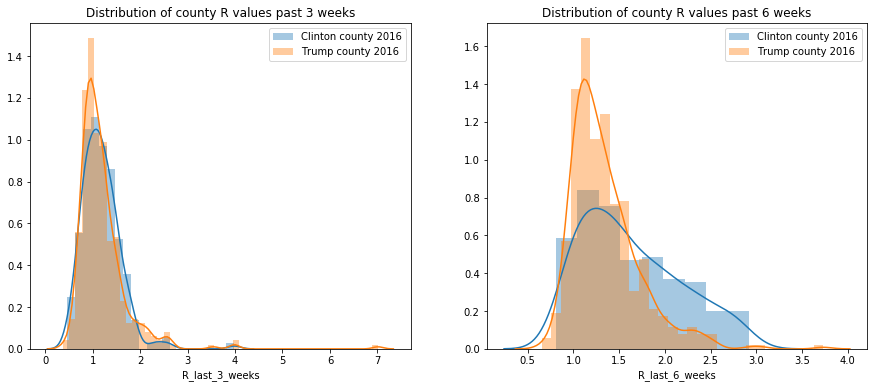

In [31]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub["R_last_3_weeks"].dropna(), ax=ax[0])
ax[0].legend(["Clinton county 2016", "Trump county 2016"])

ax[0].set_title("Distribution of county R values past 3 weeks")


for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub["R_last_6_weeks"].dropna(), ax=ax[1])
ax[1].legend(["Clinton county 2016", "Trump county 2016"])

ax[1].set_title("Distribution of county R values past 6 weeks")

Interestingly, the distribution of R value from the last 3 weeks are very similar. We may not want to keep that feature in our model.

Text(0.5, 1.0, 'Distribution of state R values over previous 6 weeks')

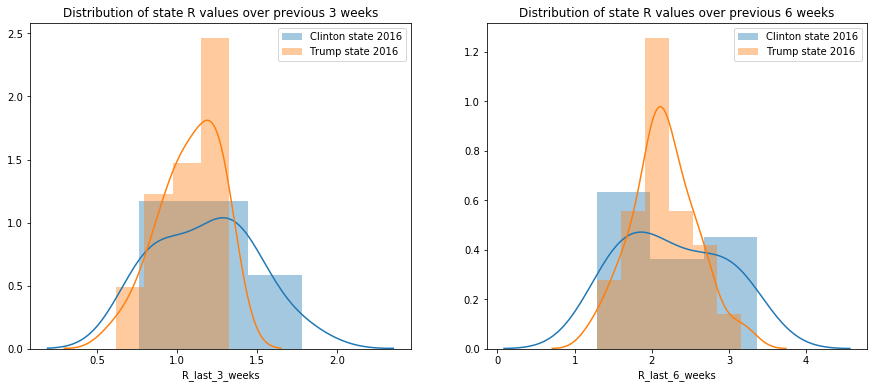

In [32]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

for trump in range(0,2):
    state_sub = state_train[state_train["StateVotedTrump"]== trump]
    sns.distplot(state_sub["R_last_3_weeks"].dropna(), ax=ax[0])
    
ax[0].legend(["Clinton state 2016", "Trump state 2016"])
ax[0].set_title("Distribution of state R values over previous 3 weeks")

for trump in range(0,2):
    state_sub = state_train[state_train["StateVotedTrump"]== trump]
    sns.distplot(state_sub["R_last_6_weeks"].dropna(), ax=ax[1])
    
ax[1].legend(["Clinton state 2016", "Trump state 2016"])
ax[1].set_title("Distribution of state R values over previous 6 weeks")

These distributions are different enough such that it may be helpful to keep both features. We might also want to look at $R$ estimates over earlier periods of time.

# Process Data

The following functions process the data and create the X and y arrays.

In [33]:
def process_data(df, state=True):
    """
    Input: df (county or state-level df), state=True if state-level data, False if county-level data
    Returns: processed dataframe with all features
    """
    if state==False:
        pd.set_option('mode.chained_assignment', None) #this is to make that slice error go away
        orders_columns = ['stay at home', '>50 gatherings',
                          '>500 gatherings', 'public schools', 'restaurant dine-in',
                          'entertainment/gym']
        df = add_state_orders_features_to_df(df, orders_columns)
        df["numeric_FIPS"] = pd.to_numeric(df["FIPS"])
        
        R_df = calculate_R(df["numeric_FIPS"])["R"].rename("R_last_3_weeks")
        R_df = pd.DataFrame(R_df)
        R_df["R_last_6_weeks"] = calculate_R(df["numeric_FIPS"], start_date = 46 )["R"]

        return pd.merge(df, R_df, left_on = "numeric_FIPS", right_index=True)
    
    else:
        df = pd.merge(df, create_state_beta_table(), left_on="State", right_index=True) # merge
        R_df = calculate_R(df["State"])["R"].rename("R_last_3_weeks")
        R_df = pd.DataFrame(R_df)
        R_df["R_last_6_weeks"] = calculate_R(df["State"], start_date = 46 )["R"]

        return pd.merge(df, R_df, left_on = "State", right_index=True)
    
def select_features(df, x_columns, continuous_y=True):
    """
    Input: 
    Dataframe
    x_columns = list of strings of column names
    Continuous = True if using the continous Y variable, False if using binary
    Output: Y-variable array
    Note: this only works for county-level data
    """
    X = df[x_columns]
    X = X.apply(lambda x: x.fillna(x.mean()),axis=0) #impute mean for NA columns
    X = X[x_columns].to_numpy()

    if continuous_y == True:
        y = df['VotedTrump2016Cont'].to_numpy()
    else: 
        y = df['VotedTrump2016'].to_numpy() #Binary y variable for logistic regression

    return X, y

In [34]:
y_cont_train = county_train['PresElectCont'].to_numpy() #Continuous y variable for linear regression

x_columns = ['grocery', 'parks', 'residential', 'retail', 'transit', 'workplaces',  #Mobility
             'stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
             'restaurant dine-in', 'entertainment/gym',
             'R_last_3_weeks', 'R_last_6_weeks' #R
             ]

X_train, y_cont_train_2016 = select_features(county_train, x_columns, continuous_y = True)
y_bin_train = select_features(county_train, x_columns, continuous_y = False)[1]

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import ensemble

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X)) ** 2))

#### Linear Regression Model with 2000 - 2016 Election Results

In [36]:
state_train.head()

State STATEFP  StateVotedTrump  date_ord    grocery      parks  \
0     Alabama      01                1    737516  -0.274510  13.352941   
1     Arizona      04                1    737516  -7.274510 -12.725490   
2    Arkansas      05                1    737516   0.862745  34.725490   
3  California      06                0    737516 -10.941176 -29.235294   
4    Colorado      08                0    737516 -10.490196   1.509804   

   residential     retail    transit  workplaces  beta0      beta1     beta2  \
0    10.882353 -24.470588 -18.666667  -27.941176    0.0  16.407425 -0.432553   
1    12.117647 -28.019608 -29.647059  -33.705882    0.0   8.568596 -0.228816   
2     9.235294 -19.588235 -16.862745  -25.392157    0.0   4.649976 -0.133855   
3    17.019608 -38.509804 -45.019608  -38.411765    0.0  93.061622 -1.500801   
4    15.313725 -34.686275 -44.647059  -38.470588    0.0  32.468041 -0.852440   

   R_last_3_weeks  R_last_6_weeks  
0        1.310210        2.101688  
1        0.990022        2.192635  
2        1.270427        1.574975  
3        1.043304        2.178941  
4        1.283584        1.794353

In [37]:
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X_train, y_cont_train)
y_cont_train_pred = lin_model.predict(X_train)

print("Mean of y", y_cont_train.mean())
print("Std of y", y_cont_train.std())
print("\n")
print("RMSE:", rmse(y_cont_train,y_cont_train_pred))
print("RMSE when guessing the mean y:", rmse(y_cont_train,y_cont_train.mean()))
print("Correlation Coefficient:", lin_model.score(X_train, y_cont_train))
print("CV Score:", cross_val_score(lin_model, X_train, y_cont_train, cv=25, scoring=rmse_score).mean())

Mean of y 0.3542133374277348
Std of y 0.46695475176288764


RMSE: 0.4150728110192064
RMSE when guessing the mean y: 0.46695475176288764
Correlation Coefficient: 0.20986923127514834
CV Score: 0.4239446349583264


#### Linear Regression Model with only 2016 Election Results

In [38]:
state_train.head()

State STATEFP  StateVotedTrump  date_ord    grocery      parks  \
0     Alabama      01                1    737516  -0.274510  13.352941   
1     Arizona      04                1    737516  -7.274510 -12.725490   
2    Arkansas      05                1    737516   0.862745  34.725490   
3  California      06                0    737516 -10.941176 -29.235294   
4    Colorado      08                0    737516 -10.490196   1.509804   

   residential     retail    transit  workplaces  beta0      beta1     beta2  \
0    10.882353 -24.470588 -18.666667  -27.941176    0.0  16.407425 -0.432553   
1    12.117647 -28.019608 -29.647059  -33.705882    0.0   8.568596 -0.228816   
2     9.235294 -19.588235 -16.862745  -25.392157    0.0   4.649976 -0.133855   
3    17.019608 -38.509804 -45.019608  -38.411765    0.0  93.061622 -1.500801   
4    15.313725 -34.686275 -44.647059  -38.470588    0.0  32.468041 -0.852440   

   R_last_3_weeks  R_last_6_weeks  
0        1.310210        2.101688  
1        0.990022        2.192635  
2        1.270427        1.574975  
3        1.043304        2.178941  
4        1.283584        1.794353

In [39]:
lin_model_2016 = LinearRegression(fit_intercept=True)
lin_model_2016.fit(X_train, y_cont_train_2016)
y_cont_train_pred_2016 = lin_model.predict(X_train)

print("Mean of y", y_cont_train_2016.mean())
print("Std of y", y_cont_train_2016.std())
print("\n")
print("RMSE:", rmse(y_cont_train_2016, y_cont_train_pred_2016))
print("RMSE when guessing the mean y:", rmse(y_cont_train_2016, y_cont_train_2016.mean()))
print("Correlation Coefficient:", lin_model.score(X_train, y_cont_train_2016))
print("CV Score:", cross_val_score(lin_model_2016, X_train, y_cont_train_2016, cv=25, scoring=rmse_score).mean())

Mean of y 0.4575177809305651
Std of y 0.48315577627772915


RMSE: 0.43590107838542397
RMSE when guessing the mean y: 0.48315577627772915
Correlation Coefficient: 0.18604286438577067
CV Score: 0.41664696803278545


#### Logistic Regression Model

In [40]:
log_model = LogisticRegressionCV(cv=10, fit_intercept=True, solver='liblinear')
log_model.fit(X_train, y_bin_train)
y_bin_train_pred = log_model.predict(X_train)

print("Mean of y", y_bin_train.mean())
print("Std of y", y_bin_train.std())
print("\n")
print("CV Score:", log_model.score(X_train, y_bin_train))

Mean of y 0.8293016887266088
Std of y 0.37624512993765596


CV Score: 0.8293016887266088


#### Decision Tree Model

In [41]:
decision_tree_model = tree.DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_bin_train)
cross_val_score(decision_tree_model, X_train, y_bin_train, cv=25, scoring='accuracy').mean()

0.7544960025272777

#### Random Forest Model

In [42]:
random_forest_model = ensemble.RandomForestClassifier(20, random_state=42)
random_forest_model.fit(X_train, y_bin_train)
cross_val_score(random_forest_model, X_train, y_bin_train, cv=25, scoring='accuracy').mean()

0.8284046560229399

# Process Data & Test the Model

Now that we have decided what features to use, we'll look at the test data.

In [43]:
x_columns = ['grocery', 'parks', 'residential', 'retail', 'transit', 'workplaces',  #Mobility
             'stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
             'restaurant dine-in', 'entertainment/gym',
             'R_last_3_weeks', 'R_last_6_weeks' #R
            ]

county_test = process_data(county_test, state=False)

#County Level Test data
y_test_cont = county_test['PresElectCont'].to_numpy()
X_test, y_test_cont_2016 = select_features(county_test, x_columns, continuous_y=True)
y_test_bin = select_features(county_test, x_columns, continuous_y=False)[1]

#### Linear Model Testing Accuracy

In [44]:
print('Linear Model (2000-2016):', rmse_score(lin_model, X_test, y_test_cont))
print('Linear Model (2016):', rmse_score(lin_model_2016, X_test, y_test_cont_2016))

Linear Model (2000-2016): 0.38476329488689515
Linear Model (2016): 0.3896410949401591


#### Binary Model Testing Accuracy

In [45]:
print('Logistic Regression Test Accuracy:', log_model.score(X_test, y_test_bin))
print('Decision Tree Test Accuracy:', decision_tree_model.score(X_test, y_test_bin))
print('Random Forest Test Accuracy:', random_forest_model.score(X_test, y_test_bin))

Logistic Regression Test Accuracy: 0.8521897810218978
Decision Tree Test Accuracy: 0.843065693430657
Random Forest Test Accuracy: 0.8978102189781022


# Plotting Predictions

Now that we have tested our data, let's look at how model sees America.

In [46]:
predict_df = process_data(county_merged_df, state=False)
predict_df.loc[:, x_columns] = predict_df.loc[:, x_columns].apply(lambda x: x.fillna(x.mean()),axis=0)
predict_df['Lin_Prediction'] = lin_model.predict(predict_df.loc[:, x_columns])
predict_df['Lin_2016_Prediction'] = lin_model_2016.predict(predict_df.loc[:, x_columns])
predict_df['Log_Prediction'] = log_model.predict(predict_df.loc[:, x_columns])
predict_df['Tree_Prediction'] = decision_tree_model.predict(predict_df.loc[:, x_columns])
predict_df['Forest_Prediction'] = random_forest_model.predict(predict_df.loc[:, x_columns])

predict_df.head()

FIPS STATEFP CountyName StateName    State  stay at home  >50 gatherings  \
0  01001      01    Autauga        AL  Alabama      737519.0        737504.0   
1  01003      01    Baldwin        AL  Alabama      737519.0        737504.0   
2  01005      01    Barbour        AL  Alabama      737519.0        737504.0   
3  01007      01       Bibb        AL  Alabama      737519.0        737504.0   
4  01009      01     Blount        AL  Alabama      737519.0        737504.0   

   >500 gatherings  public schools  restaurant dine-in  ...  \
0         737497.0        737500.0            737503.0  ...   
1         737497.0        737500.0            737503.0  ...   
2         737497.0        737500.0            737503.0  ...   
3         737497.0        737500.0            737503.0  ...   
4         737497.0        737500.0            737503.0  ...   

   entertainment/gym same for whole state  \
0                                    True   
1                                    True   
2                                    True   
3                                    True   
4                                    True   

   entertainment/gym relative to state  numeric_FIPS  R_last_3_weeks  \
0                                  0.0          1001        1.196914   
1                                  0.0          1003        1.375101   
2                                  0.0          1005        1.196914   
3                                  0.0          1007        1.242232   
4                                  0.0          1009        1.196914   

   R_last_6_weeks  Lin_Prediction  Lin_2016_Prediction  Log_Prediction  \
0        1.431994        0.441898             0.458916               1   
1        1.489808        0.468513             0.497262               1   
2        1.431994        0.563299             0.622729               1   
3        1.242232        0.564051             0.631484               1   
4        1.010837        0.490701             0.546600               1   

   Tree_Prediction  Forest_Prediction  
0                1                  1  
1                1                  1  
2                1                  1  
3                1                  1  
4                1                  1  

[5 rows x 53 columns]

In [47]:
print('Linear Model Actual RMSE (2000-2016):', rmse(predict_df['Lin_Prediction'],  predict_df['PresElectCont']))
print('Linear Model Actual RMSE (2016):', rmse(predict_df['Lin_2016_Prediction'],  predict_df['VotedTrump2016Cont']))
print('Logistic Regression Actual Accuracy:', log_model.score(predict_df.loc[:, x_columns], predict_df['VotedTrump2016']))
print('Decision Tree Actual Accuracy:', decision_tree_model.score(predict_df.loc[:, x_columns], predict_df['VotedTrump2016']))
print('Random Forest Actual Accuracy:', random_forest_model.score(predict_df.loc[:, x_columns], predict_df['VotedTrump2016']))

Linear Model Actual RMSE (2000-2016): 0.4092203333648828
Linear Model Actual RMSE (2016): 0.4103876876642038
Logistic Regression Actual Accuracy: 0.8338809784592918
Decision Tree Actual Accuracy: 0.9686016794450529
Random Forest Actual Accuracy: 0.9755385177071924


In [48]:
actual_map_lin = county_shp.merge(predict_df.loc[:, ('PresElectCont','FIPS')], on='FIPS').cx[-130:-50, 20:]
actual_map_lin_2016 = county_shp.merge(predict_df.loc[:, ('VotedTrump2016Cont','FIPS')], on='FIPS').cx[-130:-50, 20:]
actual_map_bin = county_shp.merge(predict_df.loc[:, ('VotedTrump2016','FIPS')], on='FIPS').cx[-130:-50, 20:]

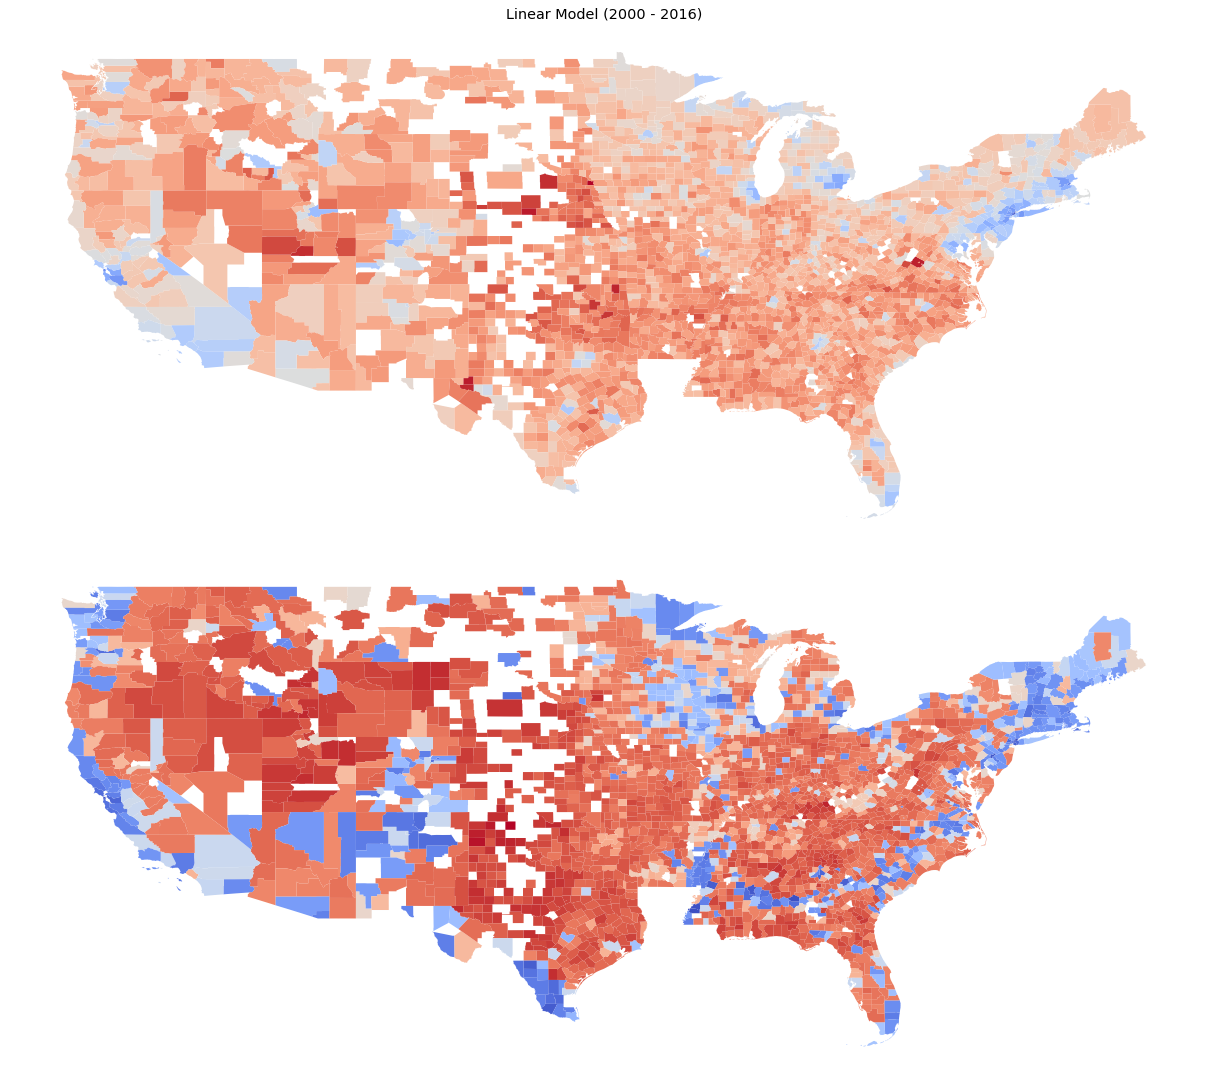

In [49]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)
trump_col = mpatches.Patch(color='red',alpha = 1.0, label='Trump')
clinton_col = mpatches.Patch(color='blue',alpha = 1.0, label='Clinton')


predicted_map = county_shp.merge(predict_df.loc[:, ('Lin_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Lin_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white')
actual_map_lin.plot(ax=axes[1], column='PresElectCont', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Linear Model (2000 - 2016)', y=1.01, size='x-large')
plt.tight_layout();
axes[0].set_axis_off()
axes[1].set_axis_off()

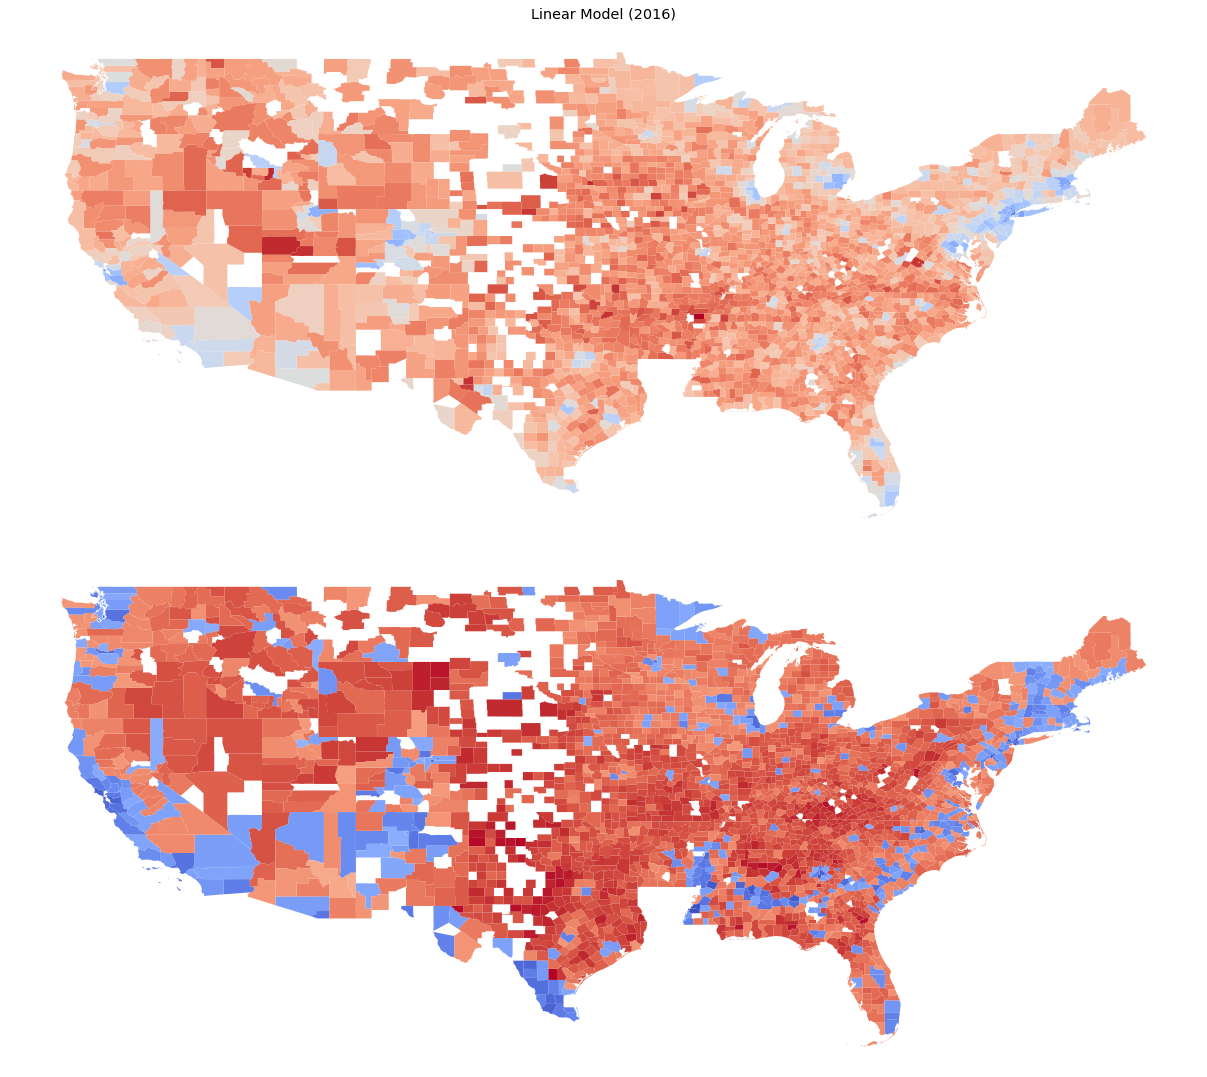

In [152]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_map = county_shp.merge(predict_df.loc[:, ('Lin_2016_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Lin_2016_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white')
actual_map_lin_2016.plot(ax=axes[1], column='VotedTrump2016Cont', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Linear Model (2016)', y=1.01, size='x-large')
plt.tight_layout();
axes[0].set_axis_off()
axes[1].set_axis_off()


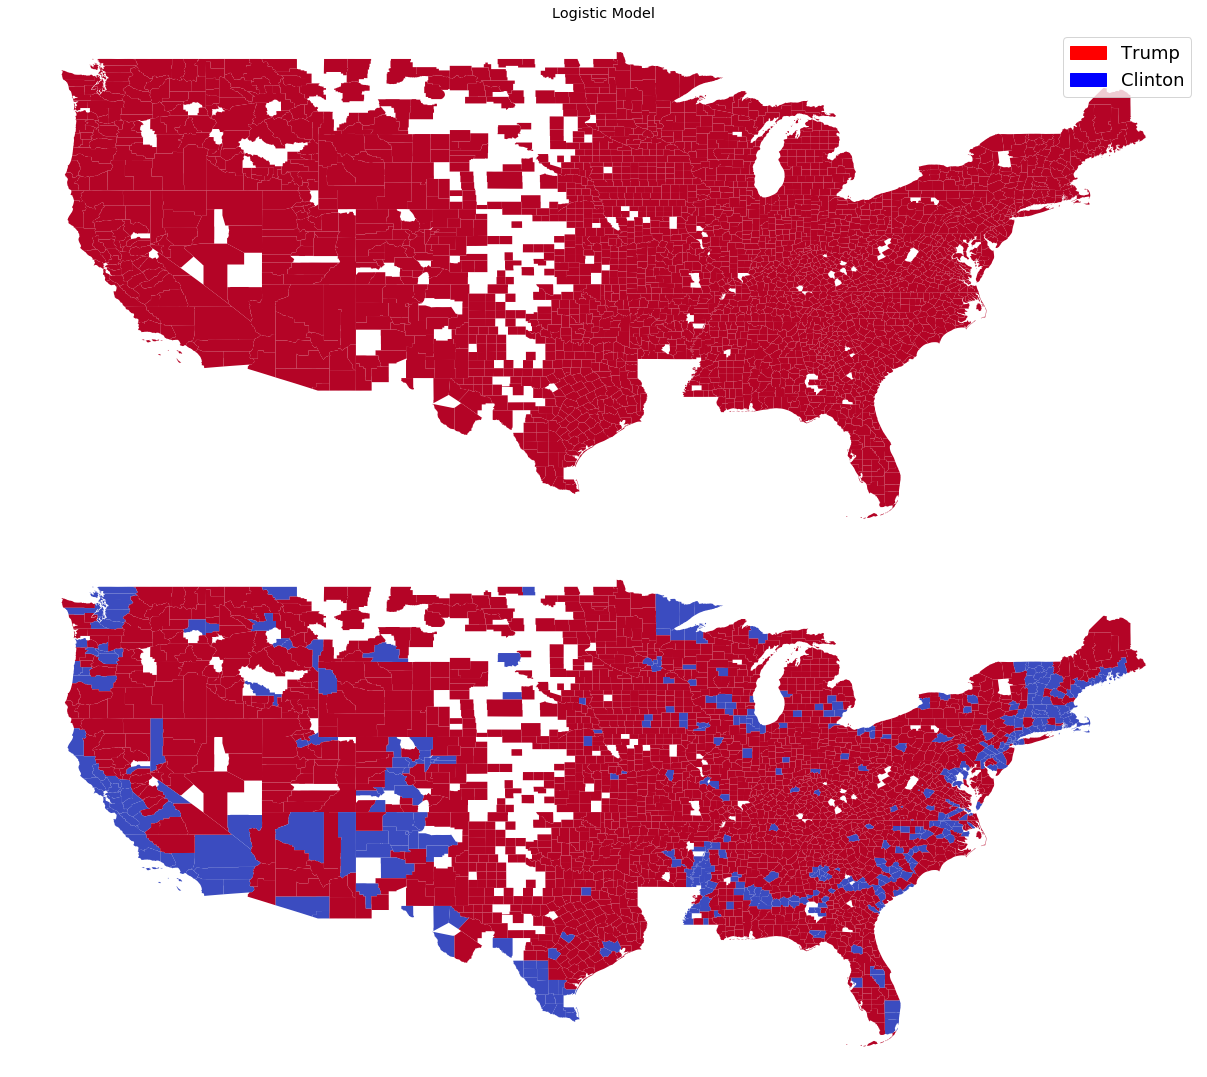

In [148]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_map = county_shp.merge(predict_df.loc[:, ('Log_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Log_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white', vmin=0, vmax=1)
actual_map_bin.plot(ax=axes[1], column='VotedTrump2016', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Logistic Model', y=1.01, size='x-large')
plt.tight_layout();
axes[0].set_axis_off()
axes[1].set_axis_off()

axes[0].legend(handles = [trump_col, clinton_col], loc =1,prop={'size':18})

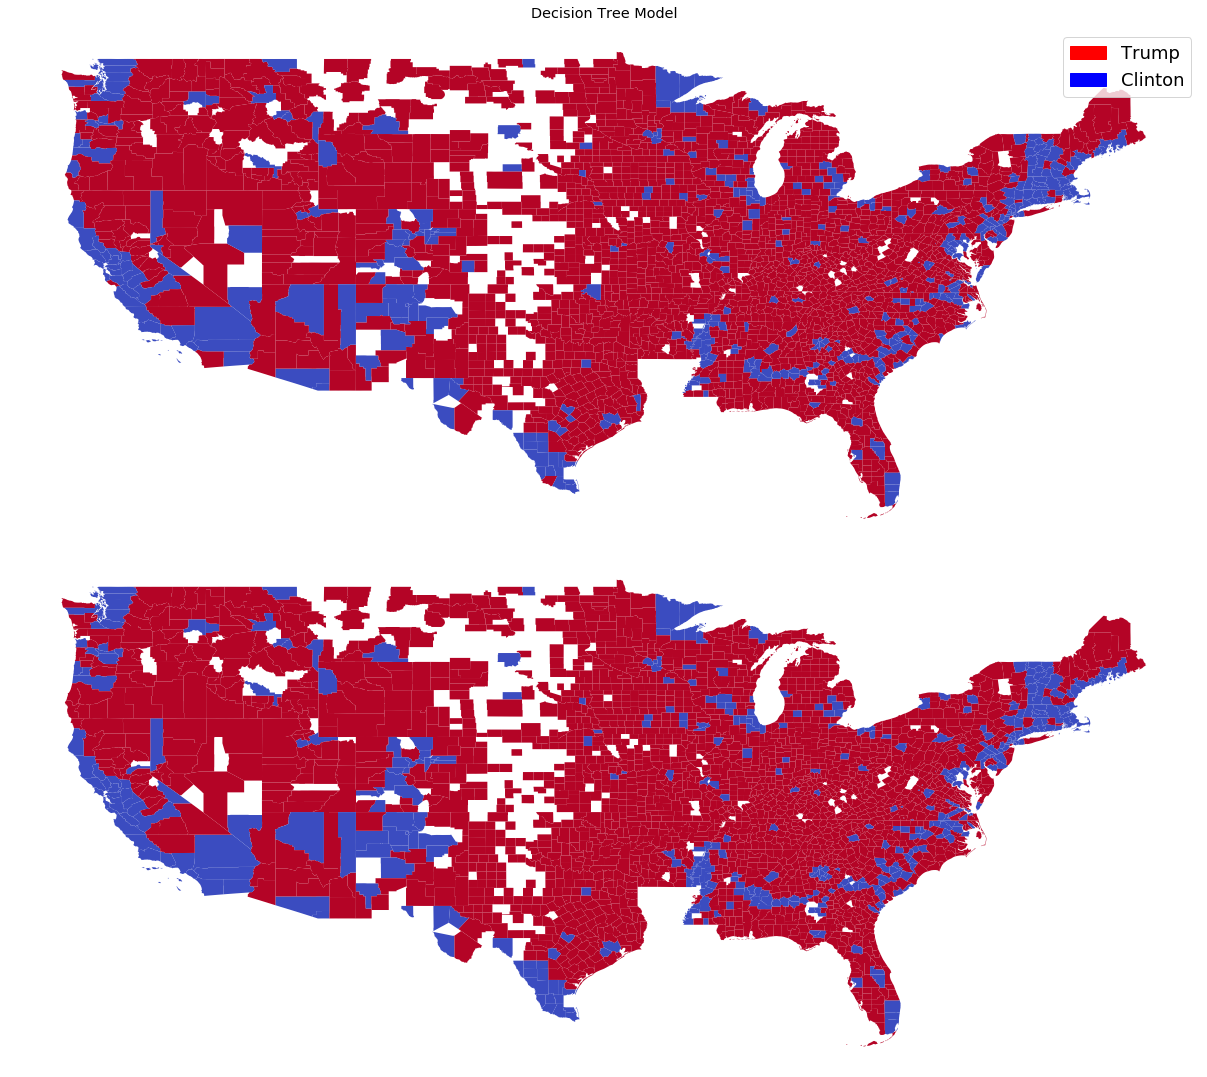

In [149]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_map = county_shp.merge(predict_df.loc[:, ('Tree_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Tree_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white')
actual_map_bin.plot(ax=axes[1], column='VotedTrump2016', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Decision Tree Model', y=1.01, size='x-large')
plt.tight_layout();
axes[0].set_axis_off()
axes[1].set_axis_off()

axes[0].legend(handles = [trump_col, clinton_col], loc =1,prop={'size':18})

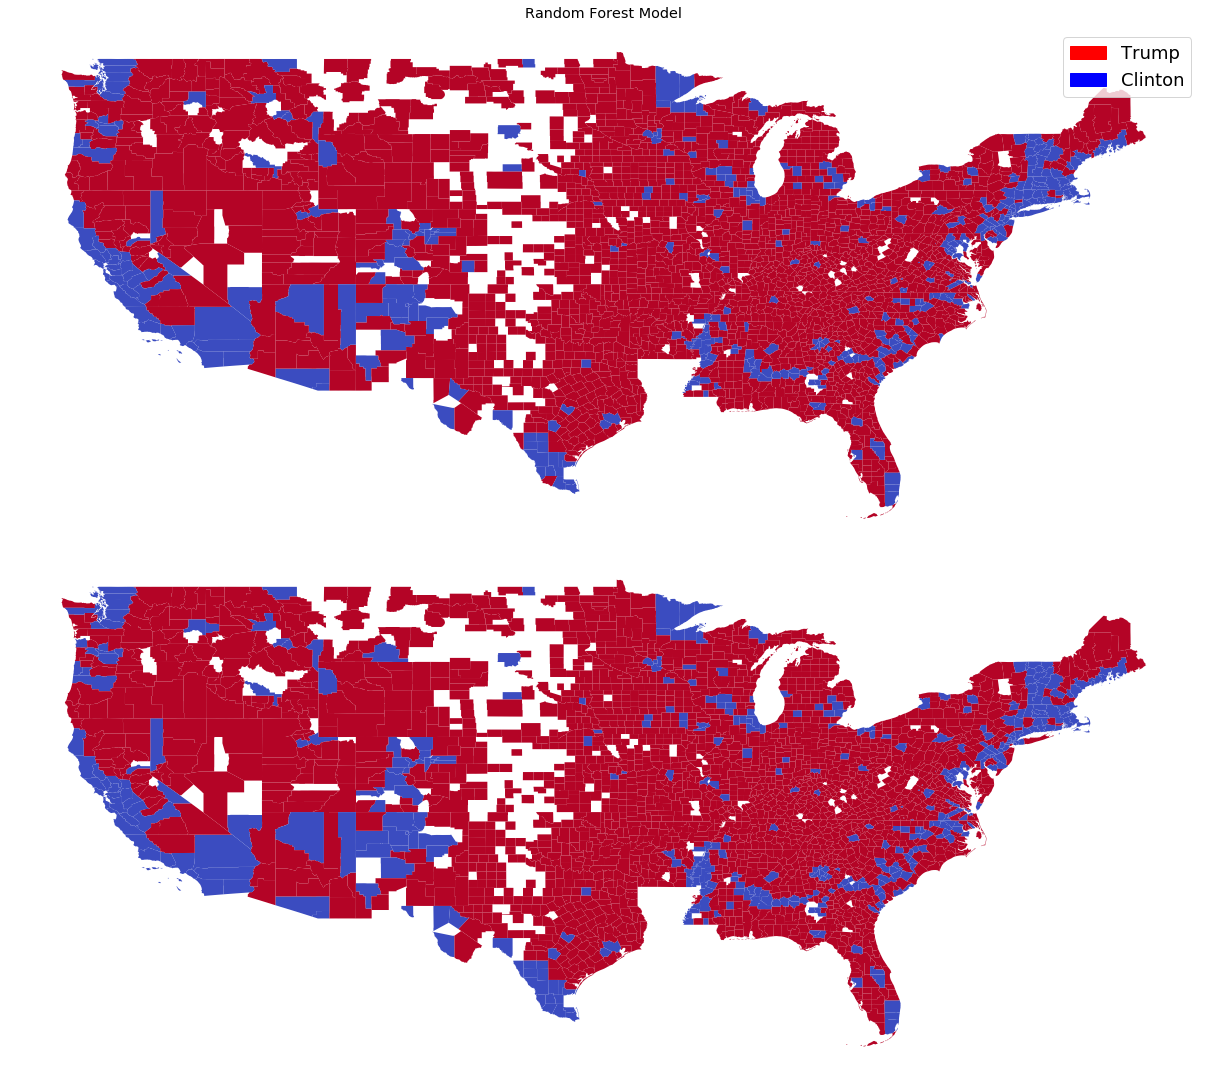

In [150]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_map = county_shp.merge(predict_df.loc[:, ('Forest_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Forest_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white')
actual_map_bin.plot(ax=axes[1], column='VotedTrump2016', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Random Forest Model', y=1.01, size='x-large')


plt.tight_layout();
axes[0].set_axis_off()
axes[1].set_axis_off()


axes[0].legend(handles = [trump_col, clinton_col], loc =1,prop={'size':18})

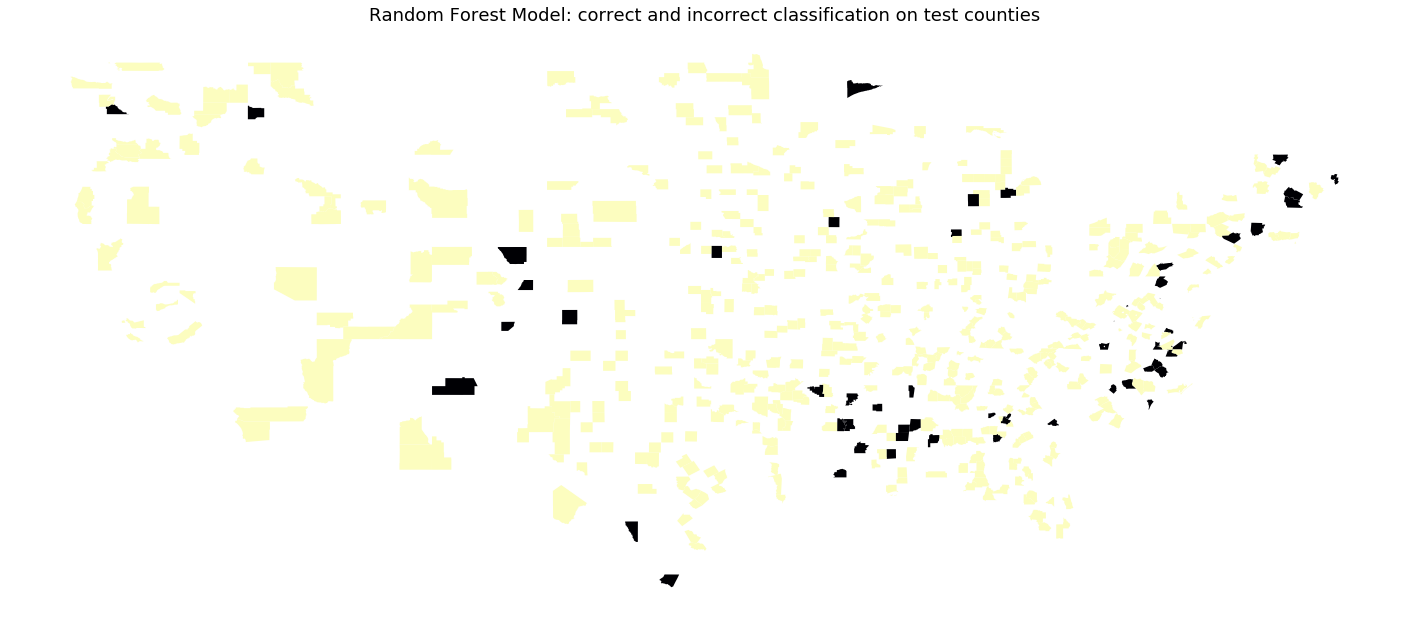

In [151]:
predicted_test_counties = predicted_map[predicted_map["FIPS"].isin(county_test["FIPS"])]
actual_map_bin_test_counties = actual_map_bin[actual_map_bin["FIPS"].isin((county_test["FIPS"]))]

predicted_test_counties["Forest_Correct"] = (predicted_test_counties["Forest_Prediction"]==actual_map_bin_test_counties["VotedTrump2016"]).astype(int)
fig, axes = plt.subplots(1, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_test_counties.plot(ax=axes, column='Forest_Correct', cmap='magma', linewidth=0, edgecolor='white')

axes.set_title("Random Forest Model: correct and incorrect classification on test counties", size = 18)

axes.set_axis_off()